 The goal of this first notebook is to figure out what the data looks like, how it is organized, etc. in order to start EDA in the next one. It does not contains all the paths I followed as just wanted to get a quick insight of what was going on.

In [1]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import scipy.io
from pylab import pi
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from datetime import datetime

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/m5-forecasting-uncertainty/calendar.csv
/kaggle/input/m5-forecasting-uncertainty/sell_prices.csv
/kaggle/input/m5-forecasting-uncertainty/sales_train_validation.csv
/kaggle/input/m5-forecasting-uncertainty/sales_train_evaluation.csv
/kaggle/input/m5-forecasting-uncertainty/sample_submission.csv


Pinball Loss & Weighted Pinball Loss

In [4]:
sellPrices = pd.read_csv('/kaggle/input/m5-forecasting-uncertainty/sell_prices.csv')

In [5]:
Calendar = pd.read_csv('/kaggle/input/m5-forecasting-uncertainty/calendar.csv')
salesTrain = pd.read_csv('../input/m5-forecasting-uncertainty/sales_train_evaluation.csv')

In [6]:
level1 = salesTrain.groupby('state_id').sum().sum()
level2 = salesTrain.groupby('state_id').sum()
level3 = salesTrain.groupby('store_id').sum()
level4 = salesTrain.groupby('cat_id').sum()
level5 = salesTrain.groupby('dept_id').sum()
level6 = salesTrain.groupby(['state_id','cat_id']).sum()
level7 = salesTrain.groupby(['state_id','dept_id']).sum()
level8 = salesTrain.groupby(['store_id','cat_id']).sum()
level9 = salesTrain.groupby(['store_id','dept_id']).sum()
level10 = salesTrain.groupby('item_id').sum()
level11 = salesTrain.groupby(['item_id','state_id']).sum()
level12 = salesTrain.groupby(['item_id','store_id']).sum()

In [7]:
tlvl4 = level4.transpose()
diff_lvl4 = tlvl4.shift(periods = 1)
diff_lvl4['FOODS'] = tlvl4['FOODS'] - diff_lvl4['FOODS']
diff_lvl4['HOUSEHOLD'] = tlvl4['HOUSEHOLD'] - diff_lvl4['HOUSEHOLD']
diff_lvl4['HOBBIES'] = tlvl4['HOBBIES'] - diff_lvl4['HOBBIES']

0        HOBBIES_1_001
1        HOBBIES_1_002
2        HOBBIES_1_003
3        HOBBIES_1_004
4        HOBBIES_1_005
             ...      
30485      FOODS_3_823
30486      FOODS_3_824
30487      FOODS_3_825
30488      FOODS_3_826
30489      FOODS_3_827
Name: item_id, Length: 30490, dtype: object

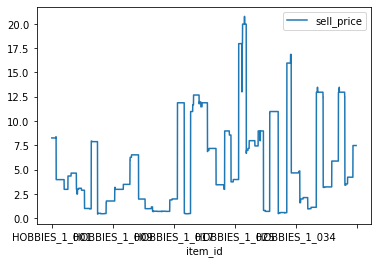

In [8]:
shorten_sp = sellPrices.loc[12:10000]
shorten_sp.plot(x = 'item_id',y = 'sell_price')
total_duration = 1941 
salesTrain.pop('item_id')

In [9]:
X = Calendar.copy()

In [10]:
X.pop('wm_yr_wk')
X.pop('weekday')
X.pop('date')
X.pop('snap_CA')
X.pop('snap_WI')
X.pop('snap_TX')
X.pop('event_type_1')
X.pop('event_type_2')
X.pop('event_name_1')
X.pop('event_name_2')
X.pop('d')

0          d_1
1          d_2
2          d_3
3          d_4
4          d_5
         ...  
1964    d_1965
1965    d_1966
1966    d_1967
1967    d_1968
1968    d_1969
Name: d, Length: 1969, dtype: object

In [11]:
print(salesTrain)

                                  id    dept_id   cat_id store_id state_id  \
0      HOBBIES_1_001_CA_1_evaluation  HOBBIES_1  HOBBIES     CA_1       CA   
1      HOBBIES_1_002_CA_1_evaluation  HOBBIES_1  HOBBIES     CA_1       CA   
2      HOBBIES_1_003_CA_1_evaluation  HOBBIES_1  HOBBIES     CA_1       CA   
3      HOBBIES_1_004_CA_1_evaluation  HOBBIES_1  HOBBIES     CA_1       CA   
4      HOBBIES_1_005_CA_1_evaluation  HOBBIES_1  HOBBIES     CA_1       CA   
...                              ...        ...      ...      ...      ...   
30485    FOODS_3_823_WI_3_evaluation    FOODS_3    FOODS     WI_3       WI   
30486    FOODS_3_824_WI_3_evaluation    FOODS_3    FOODS     WI_3       WI   
30487    FOODS_3_825_WI_3_evaluation    FOODS_3    FOODS     WI_3       WI   
30488    FOODS_3_826_WI_3_evaluation    FOODS_3    FOODS     WI_3       WI   
30489    FOODS_3_827_WI_3_evaluation    FOODS_3    FOODS     WI_3       WI   

       d_1  d_2  d_3  d_4  d_5  ...  d_1932  d_1933  d_1934  d_

In [12]:
def events(e) :
    if (e == 'Cultural'):
        return 1
    elif (e == 'Religious'):
        return 2
    elif (e == 'Sporting'):
        return 3
    elif (e == 'National'):
        return 4
    else:
        return 0

X['month_day'] = Calendar['date']
X['month_day'] = X['month_day'].map(lambda x: x[-2:])
X['year_day'] = Calendar['date'].map(lambda x: datetime.strptime(x,'%Y-%m-%d').timetuple().tm_yday)
X['event1'] = Calendar['event_type_1'].map(events)
X['event2'] = Calendar['event_type_2'].map(events)

In [13]:
lvl1 = level1.copy()
lvl1 = lvl1.shift(31) #C'est pas tout à fait comme ça qu'on devra obtenir les ventes du mois dernier, on modifiera ça plus tard
lvl1 = lvl1.dropna()
lvl1.index = range(1910)
shortX = X[31:1941].copy()
shortX.index = range(1910)
shortX.insert(7,'last_month_sales',lvl1)

In [14]:
Y = level1[31:].copy()
Y.index = range(1910)
shortX,Y


(      wday  month  year month_day  year_day  event1  event2  last_month_sales
 0        4      3  2011        01        60       0       0           32631.0
 1        5      3  2011        02        61       0       0           31749.0
 2        6      3  2011        03        62       0       0           23783.0
 3        7      3  2011        04        63       0       0           25412.0
 4        1      3  2011        05        64       0       0           19146.0
 ...    ...    ...   ...       ...       ...     ...     ...               ...
 1905     5      5  2016        18       139       0       0           51640.0
 1906     6      5  2016        19       140       0       0           38059.0
 1907     7      5  2016        20       141       0       0           37570.0
 1908     1      5  2016        21       142       0       0           35343.0
 1909     2      5  2016        22       143       0       0           35033.0
 
 [1910 rows x 8 columns],
 0       22872
 1       